## Level 9: Unit sales of all products, agregated for each store and department 

In [1]:
import os
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt

from tsforest.trend import compute_trend_models
from tsforest.forecaster import LightGBMForecaster

# local modules
import sys
sys.path.append("../lib/")
from utils import compute_scaling, reduce_mem_usage
from evaluation import WRMSSEEvaluator


/home/turing/miniconda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



***

In [4]:
data = (pd.read_parquet("../input/train_dataframe.parquet")
        .groupby(["store_id","dept_id","ds"])
        .agg({"cat_id":lambda x: int(x.unique()),
              "state_id":lambda x: int(x.unique()),
              "q":"sum",
              "event_name_1":lambda x: int(x.unique()),
              #"event_type_1":lambda x: int(x.unique()),
              #"event_name_2":lambda x: int(x.unique()),
              #"event_type_2":lambda x: int(x.unique()),
              #"discount_porc":"sum",
              "snap":lambda x: int(x.unique()),
              #"lag28":"sum",
              #"lag28_mean7":"sum",
              #"lag28_mean30":"sum",
              #"lag28_mean60":"sum",
              #"lag28_mean90":"sum",
              #"lag28_mean180":"sum"
             })
        .reset_index()
       )

data["q"] = data.q.astype(int)
data.rename({"q":"y"}, axis=1, inplace=True)

In [5]:
data.sort_values(["store_id","dept_id","ds"], inplace=True)
data.reset_index(drop=True, inplace=True)

In [16]:
ts_id_column = (data.loc[:, ["store_id","dept_id"]]
 .drop_duplicates()
 .assign(ts_id = np.arange(1,71))
)

In [17]:
data = pd.merge(data, ts_id_column, how="left", on=["store_id","dept_id"])

***

In [19]:
weights_level9 = pd.read_parquet("../input/weights_level9.parquet")
scaling_input = pd.read_parquet("../input/scaling_input.parquet")
scales = compute_scaling(scaling_input, agg_columns=["store_id","dept_id"]).rename({"q":"s"}, axis=1)

INFO:numexpr.utils:Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [20]:
weights = (weights_level9
    .assign(w = lambda x: x.weight/x.weight.median())
    .merge(scales, how="inner", on=["dept_id","store_id"])
    .assign(weight = lambda x: x.w/x.s)
    .drop(["w","s"], axis=1)
)

In [21]:
data = pd.merge(data, weights, how="left", on=["store_id","dept_id"])

In [22]:
#data.drop("weight", axis=1, inplace=True)
#data.drop("discount_porc", axis=1, inplace=True)

***

In [23]:
#valid_periods = [(pd.to_datetime("2015-04-25"), pd.to_datetime("2015-07-19")), ]

#valid_periods = [(pd.to_datetime("2015-04-25"), pd.to_datetime("2020-05-22")),
#                 (pd.to_datetime("2015-05-23"), pd.to_datetime("2020-06-19")),
#     ]

valid_periods = [(pd.to_datetime("2016-03-27"), pd.to_datetime("2016-04-24")), ]

valid_periods

[(Timestamp('2016-03-27 00:00:00'), Timestamp('2016-04-24 00:00:00'))]

***
### Training

In [39]:
model_params = {
    'objective':'l2',
    'metric':'None',
    'num_iterations':10000,
    'early_stopping_rounds':200,
    #'max_bin': 255,
    'num_leaves': 31, 
    'learning_rate': 0.1, 
    #'min_data_in_leaf': 50,
    #'min_sum_hessian_in_leaf':1e-4,
    'feature_fraction': 0.66,
    'bagging_fraction':0.9,
    'bagging_freq':1,
    'lambda_l2':1.,
    'seed':19
}

time_features = [
    "year",
    "month",
    "year_week",
    "year_day",
    "week_day",
    "month_progress",
    "week_day_cos",
    "week_day_sin",
    "year_day_cos",
    "year_day_sin",
    "year_week_cos",
    "year_week_sin",
    "month_cos",
    "month_sin"
]

model_kwargs = {
    "model_params":model_params,
    "time_features":time_features,
    "categorical_features":{"ts_id":"default",
                            "dept_id":"default",
                            "cat_id":"default",
                            "store_id":"default",
                            "state_id":"default",
                            "event_name_1":"default", 
                            "snap":"default"},
    "ts_uid_columns":["dept_id","store_id"]
}

***

In [40]:
# 3+ years of history
train_history = 1800

############################################### 1/1 ################################################
##### Validation period: (Timestamp('2016-03-27 00:00:00'), Timestamp('2016-04-24 00:00:00')) ######
####################################################################################################


100%|██████████| 70/70 [00:09<00:00,  7.76it/s]


Training until validation scores don't improve for 200 rounds
[25]	valid_0's wrmsse: 0.760282
[50]	valid_0's wrmsse: 0.710325
[75]	valid_0's wrmsse: 0.695034
[100]	valid_0's wrmsse: 0.689535
[125]	valid_0's wrmsse: 0.689312
[150]	valid_0's wrmsse: 0.687457
[175]	valid_0's wrmsse: 0.690389
[200]	valid_0's wrmsse: 0.683689
[225]	valid_0's wrmsse: 0.682169
[250]	valid_0's wrmsse: 0.677977
[275]	valid_0's wrmsse: 0.678666
[300]	valid_0's wrmsse: 0.67665
[325]	valid_0's wrmsse: 0.677836
[350]	valid_0's wrmsse: 0.677938
[375]	valid_0's wrmsse: 0.676434
[400]	valid_0's wrmsse: 0.67575
[425]	valid_0's wrmsse: 0.673095
[450]	valid_0's wrmsse: 0.67219
[475]	valid_0's wrmsse: 0.671863
[500]	valid_0's wrmsse: 0.670293
[525]	valid_0's wrmsse: 0.672998
[550]	valid_0's wrmsse: 0.671974
[575]	valid_0's wrmsse: 0.669787
[600]	valid_0's wrmsse: 0.669571
[625]	valid_0's wrmsse: 0.669416
[650]	valid_0's wrmsse: 0.669363
[675]	valid_0's wrmsse: 0.669617
[700]	valid_0's wrmsse: 0.668974
[725]	valid_0's wrms

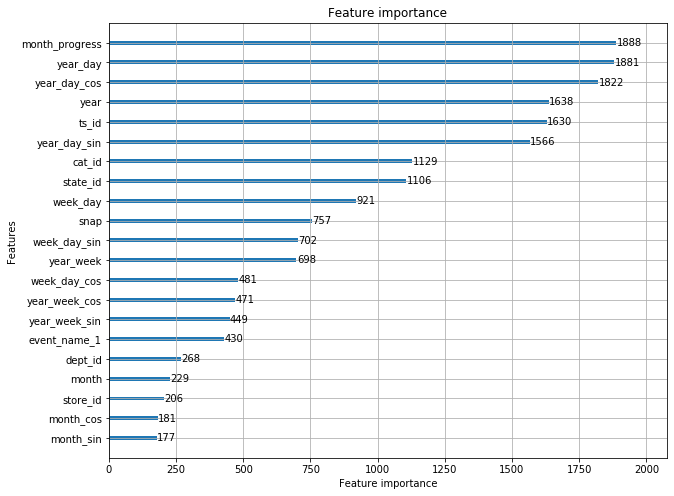

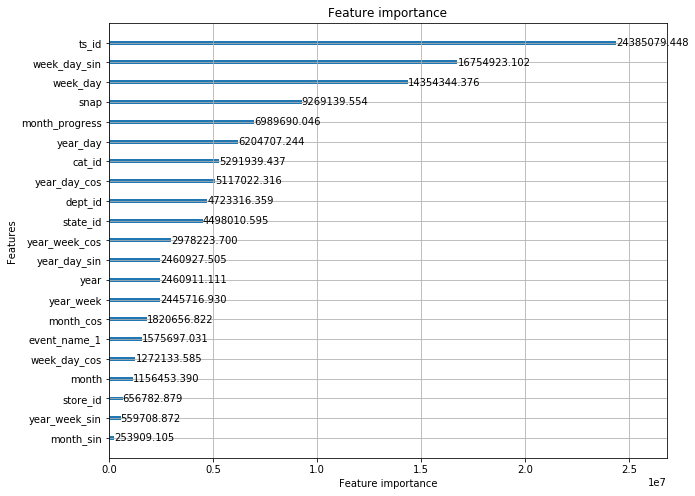

In [41]:
models = list()
errors = list()
best_iterations = list()

for i,valid_period in enumerate(valid_periods):
    print(f" {i+1}/{len(valid_periods)} ".center(100, "#"))
    print(f" Validation period: {valid_period} ".center(100, "#"))
    print("#"*100)
    
    valid_start = valid_period[0]
    valid_end = valid_period[1]
    
    train_start = valid_start - pd.DateOffset(days=train_history)
        
    _train_data = data.query("@train_start <= ds <= @valid_end").reset_index(drop=True)
    _valid_index = _train_data.query("@valid_start <= ds <= @valid_end").index

    model_kwargs["trend_models"] = compute_trend_models(_train_data,
                                                        _valid_index,
                                                        ts_uid_columns=["dept_id","store_id"])

    _fcaster = LightGBMForecaster(**model_kwargs)
    _fcaster.prepare_features(train_data=_train_data, valid_index=_valid_index);

    _fcaster.train_features = reduce_mem_usage(_fcaster.train_features)
    _fcaster.valid_features = reduce_mem_usage(_fcaster.valid_features)
    
    evaluator = WRMSSEEvaluator(_fcaster.valid_features.loc[:, ["ds"]+_fcaster.ts_uid_columns+["y"]], 
                                weights_level9, 
                                scales,
                                ts_uid_columns=_fcaster.ts_uid_columns)
    _fcaster.fit(fit_kwargs={"verbose_eval":25, "feval":evaluator.evaluate})

    lgb.plot_importance(_fcaster.model.model, importance_type="split", figsize=(10,8))
    lgb.plot_importance(_fcaster.model.model, importance_type="gain", figsize=(10,8))
    
    models.append(_fcaster)
    errors.append(_fcaster.model.model.best_score["valid_0"]["wrmsse"])
    best_iterations.append(_fcaster.best_iteration)

***

In [42]:
predictions = _fcaster.predict(_fcaster.valid_features.loc[:, data.columns.drop("y")])

In [43]:
predictions = pd.merge(predictions,
                       _fcaster.valid_features.loc[:, ["ds","dept_id","store_id","y"]], 
                       how="inner", 
                       on=["ds","dept_id","store_id"])

In [49]:
dff = data.query("store_id == 1 & dept_id == 2")

In [55]:
dff = data.groupby(["ds"])["y"].sum().reset_index()

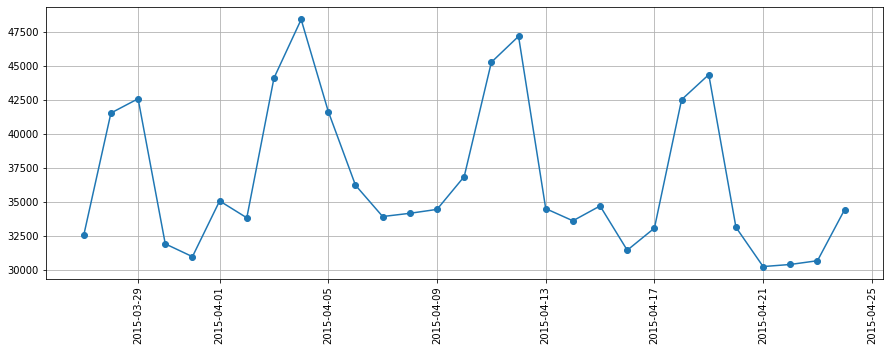

In [63]:
ldate = "2015-03-27"
rdate = "2015-04-24"

plt.figure(figsize=(15,5))
plt.plot_date(dff.query("@ldate <= ds <= @rdate").ds, dff.query("@ldate <= ds <= @rdate").y, "o-")
plt.xticks(rotation=90)
plt.grid()
plt.show()

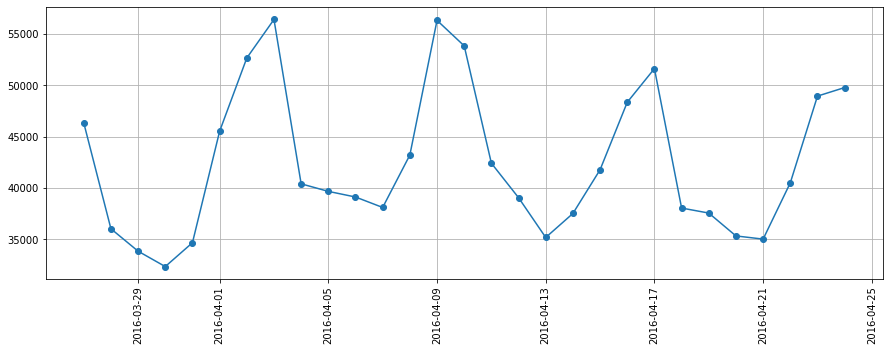

In [64]:
ldate = "2016-03-27"
rdate = "2016-04-24"

plt.figure(figsize=(15,5))
plt.plot_date(dff.query("@ldate <= ds <= @rdate").ds, dff.query("@ldate <= ds <= @rdate").y, "o-")
plt.xticks(rotation=90)
plt.grid()
plt.show()

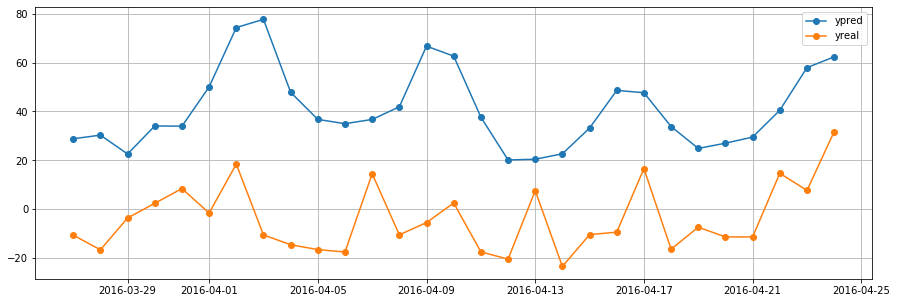

In [44]:
dept_id = 2
store_id = 1



df = predictions.query("dept_id == @dept_id & store_id == @store_id")

plt.figure(figsize=(15,5))
plt.plot_date(df.ds, df.y_pred, "o-", label="ypred")
plt.plot_date(df.ds, df.y, "o-", label="yreal")
plt.legend(loc="best")
plt.grid()
plt.show()

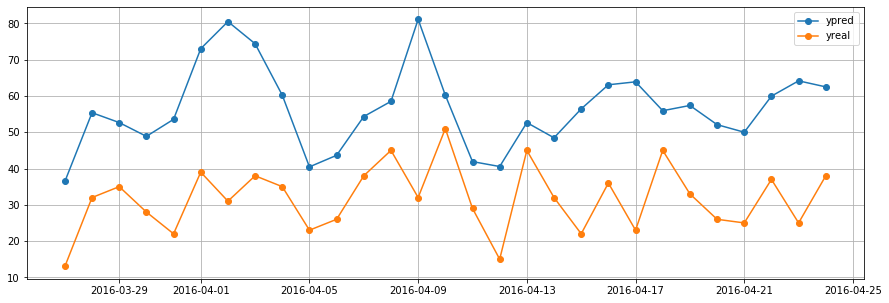

In [38]:
dept_id = 2
store_id = 9

df = predictions.query("dept_id == @dept_id & store_id == @store_id")

plt.figure(figsize=(15,5))
plt.plot_date(df.ds, df.y_pred, "o-", label="ypred")
plt.plot_date(df.ds, df.y, "o-", label="yreal")
plt.legend(loc="best")
plt.grid()
plt.show()

In [33]:
summary = (predictions
 .assign(sq_error = lambda x: (x.y_pred-x.y)**2)
 .groupby(["dept_id","store_id"])["sq_error"]
 .mean()
 .reset_index(name="mse")
 .assign(rmse = lambda x: np.sqrt(x.mse))
 .merge(scales)
 .merge(weights_level9)
 .assign(error = lambda x: x.rmse/x.s)
)
summary

,dept_id,store_id,mse,rmse,s,weight,error
0,1,1,7067.849246,84.070502,122.452884,0.017208,0.686554
1,1,2,4222.919739,64.983996,102.049108,0.011630,0.636791
2,1,3,6096.664864,78.081143,118.231598,0.017347,0.660408
3,1,4,4612.839086,67.917885,77.744226,0.010279,0.873607
4,1,5,2086.422065,45.677369,69.344895,0.008484,0.658698
...,...,...,...,...,...,...,...
65,7,6,40245.915370,200.613846,430.612307,0.034183,0.465880
66,7,7,45549.279421,213.422772,324.500404,0.030237,0.657696
67,7,8,26194.399635,161.846840,332.888867,0.030231,0.486189
68,7,9,66105.661695,257.110213,399.439088,0.040338,0.643678


In [36]:
summary.query("error > 2")

,dept_id,store_id,mse,rmse,s,weight,error
13,2,4,1378.353481,37.126183,8.182891,0.000267,4.537050
18,2,9,737.989987,27.165971,12.371600,0.000492,2.195833


***
### final model

In [71]:
train_start = data.ds.max() - pd.DateOffset(days=train_history)
train_data = data.query("ds >= @train_start").reset_index(drop=True)

In [72]:
model_kwargs["trend_models"] = compute_trend_models(train_data,
                                                    ts_uid_columns=["dept_id","store_id"])
model_kwargs["model_params"]["num_iterations"] = best_iterations[0]
model_kwargs["model_params"]

100%|██████████| 70/70 [00:12<00:00,  5.70it/s]


{'objective': 'l2',
 'metric': 'None',
 'num_iterations': 10000,
 'early_stopping_rounds': 200,
 'max_bin': 255,
 'num_leaves': 31,
 'learning_rate': 0.075,
 'feature_fraction': 0.66,
 'bagging_fraction': 0.9,
 'bagging_freq': 1,
 'lambda_l2': 1.0,
 'seed': 19}

In [73]:
fcaster = LightGBMForecaster(**model_kwargs)
fcaster.prepare_features(train_data=train_data);
fcaster.train_features = reduce_mem_usage(fcaster.train_features)
fcaster.fit(fit_kwargs={"verbose_eval":20})

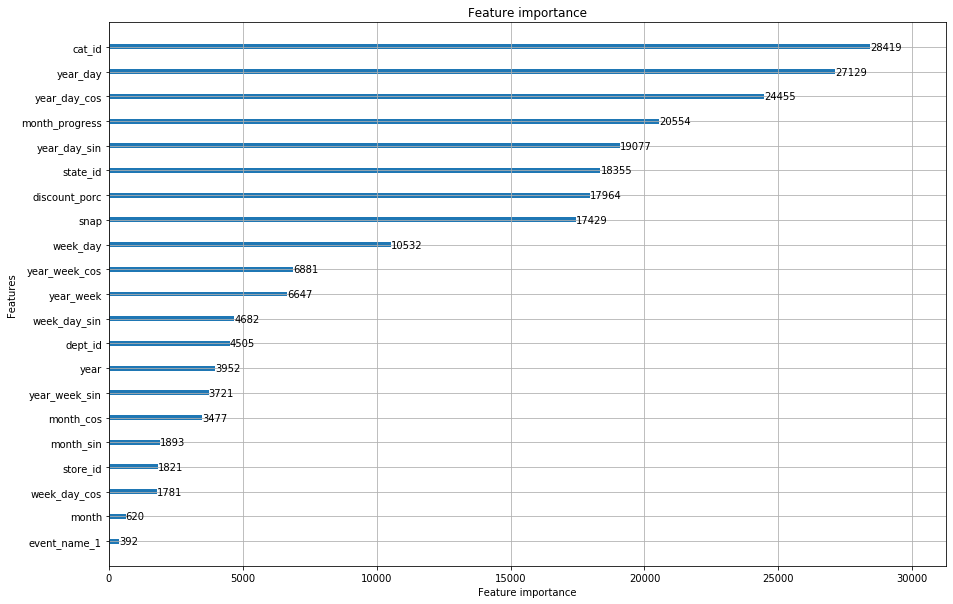

In [74]:
lgb.plot_importance(fcaster.model.model, importance_type="split", figsize=(15,10));

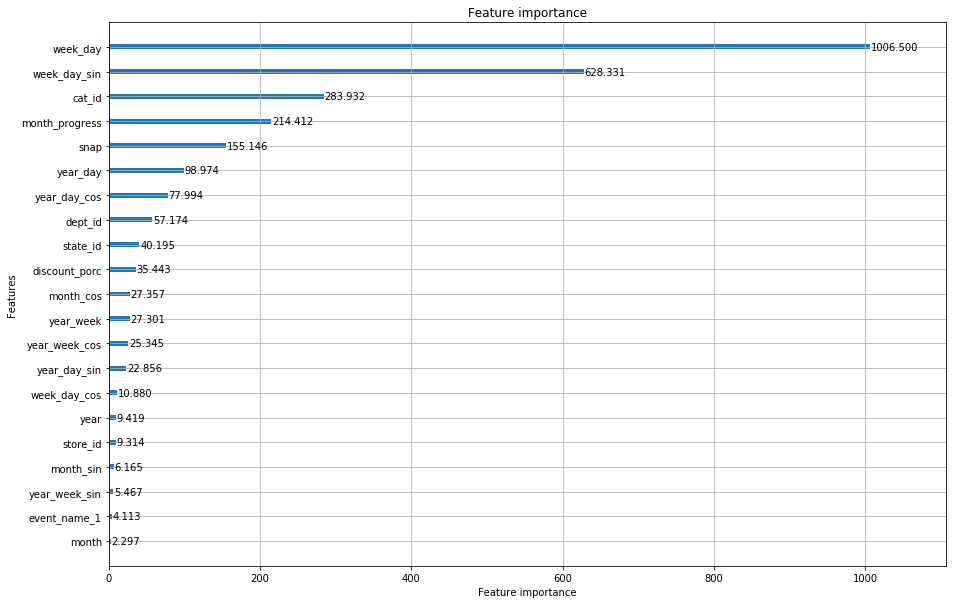

In [75]:
lgb.plot_importance(fcaster.model.model, importance_type="gain", figsize=(15,10));

***
### apply forecast distribution